In [150]:
import numpy as np
import matplotlib.pyplot as plt
import glob, uproot
import matplotlib.cm as cm
from scipy.stats import poisson

In [43]:
### calculations for solid H-3

solid_T_rho = 0.3 ## g/cm^3 (extrapolated from H2)
T_molar_mass = 3.016 ## amu
T_half_life = 12.32 ## years
T_last_ev_frac = 2.9e-13 ## fraction of decays in last eV
T_branching_ratio = 0.57 ## to bound molecular state

estar_stopping_power = 3.092E+04 ## keV cm^2/g
T_Q = 18.6 ## keV

## units
amu_to_g = 1.66e-24 
cm_to_m = 1e-2
g_to_ng = 1e9
m_to_um = 1e6
Ci_to_bq = 3.7e10
keV_to_eV = 1000
MeV_to_eV = 1e6
nm_to_um = 1e-3

In [4]:
## assume hexagonal lattice of T2 molecules, lattice parameters from 
# https://www.webelements.com/hydrogen/crystal_structure.html

## lattice parameters
a = 470e-12 # m
c = 340e-12 # m

## monolayer area density
area_density = solid_T_rho * c / cm_to_m # g/cm^2
print("Density per area [g/cm^2]: %.2e"%area_density)

Density per area [g/cm^2]: 1.02e-08


In [5]:
## calculate the tritium mass and activity for a solid tritium shell of given radius and thickness

rad_list = np.logspace(-6, -2, 100) ## radius in m
thick_list = np.logspace(np.log10(c), -4, 1000) ## thickness in m

mass_mat = np.zeros((len(rad_list), len(thick_list)))

for rad_idx, rad in enumerate(rad_list):
    for thick_idx, thick in enumerate(thick_list):

        if thick > rad:
            mass_mat[rad_idx, thick_idx] = -1
            continue 

        ## calculate the mass of tritium in a shell
        mass_mat[rad_idx, thick_idx] = 4/3 * np.pi * (rad**3 - (rad-thick)**3) * solid_T_rho / cm_to_m**3 # g

mass_mat[mass_mat < 0] = np.nan

target_mass = 200e-9 # g for 1 evt/day in last eV
T_tau = T_half_life * 365.25 * 24 * 3600 / np.log(2) # s
print("Decay rate [s^-1]: %.2e"%(1/T_tau))
print("Specific activity [Bq/g]: %.2e"%(1/(T_molar_mass * T_tau * amu_to_g)))

decay_mat = mass_mat * 1/ (T_molar_mass * amu_to_g * T_tau) # Bq

last_ev_mat = decay_mat * 24*3600 * T_last_ev_frac * T_branching_ratio ## counts per day in last eV

Decay rate [s^-1]: 1.78e-09
Specific activity [Bq/g]: 3.56e+14


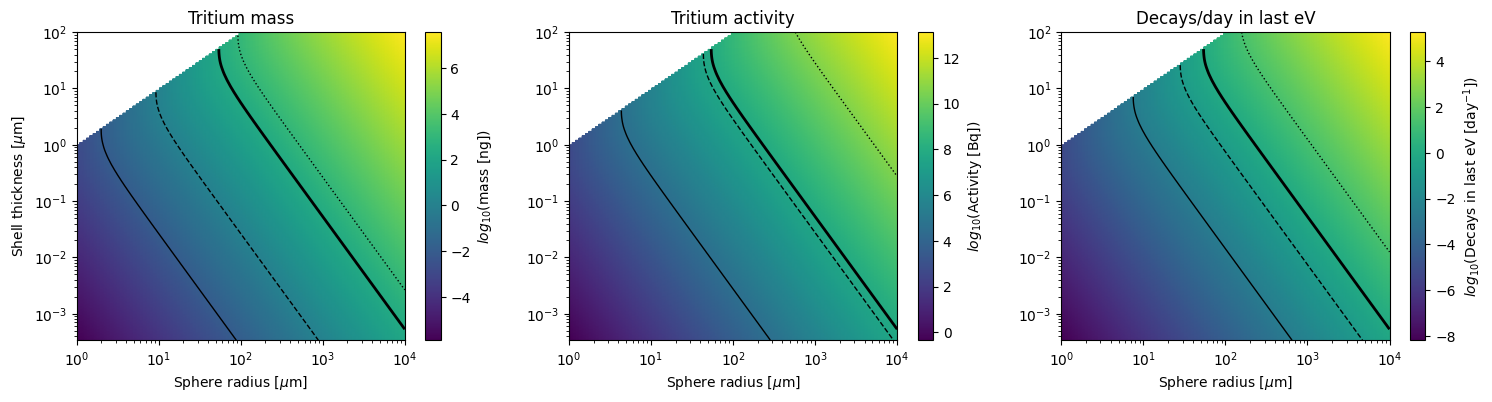

In [6]:
plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(mass_mat.T * g_to_ng), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(mass [ng])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[10e-12, 1e-9, 1e-6], colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Tritium mass")

plt.subplot(1, 3, 2)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(decay_mat.T), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
#plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(Activity [Bq])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
activity_rates = [1e-6*Ci_to_bq, 1e-3*Ci_to_bq, 1*Ci_to_bq]
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, decay_mat.T, levels=activity_rates, colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Tritium activity")

plt.subplot(1, 3, 3)
plt.pcolormesh(rad_list*m_to_um, thick_list*m_to_um, np.log10(last_ev_mat.T), shading='gouraud')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Sphere radius [$\mu$m]")
#plt.ylabel("Shell thickness [$\mu$m]")
plt.colorbar(label='$log_{10}$(Decays in last eV [day$^{-1}$])')
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, mass_mat.T, levels=[target_mass], colors=['k'], linewidths=[2])
activity_rates = [1/365, 1/7, 24]
contour = plt.contour(rad_list*m_to_um, thick_list*m_to_um, last_ev_mat.T, levels=activity_rates, colors=['k'], linestyles=['solid', "dashed","dotted"], linewidths=[1]) #, colors=['k'])
plt.title("Decays/day in last eV")

plt.show()

In [66]:
## What shell thickness is possible (?)

## maybe ask what is equivalent to KATRIN

## naive nist estar vs shell thickness:
thick_list = np.logspace(-10, -2, 100) ## thickness in m
estar_eng_loss = thick_list/cm_to_m * estar_stopping_power * solid_T_rho


In [100]:
def get_colors_from_colormap(n, colormap_name='viridis'):
    """
    Select n colors evenly spaced from a given colormap.

    Parameters:
    - n (int): Number of colors to select.
    - colormap_name (str): Name of the matplotlib colormap.

    Returns:
    - List of RGB tuples.
    """
    colormap = cm.get_cmap(colormap_name, n)  # Get colormap with n discrete colors
    return [colormap(i) for i in range(n)]  # Extract colors

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_7838/1776003015.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap_name, n)  # Get colormap with n discrete colors


Text(0, 0.5, 'Normalized counts')

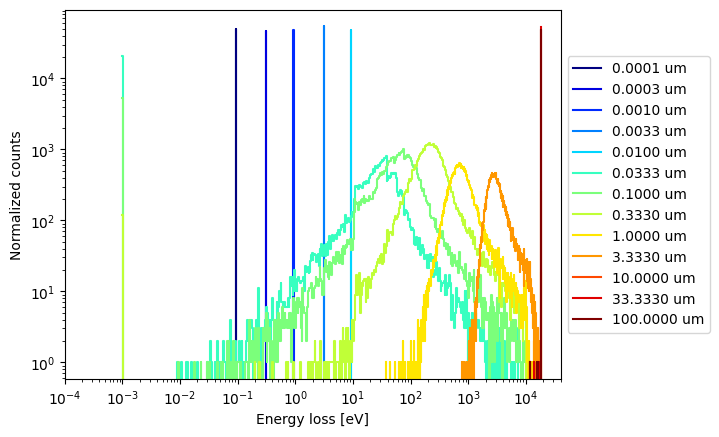

In [190]:
## g4-DNA energy loss

data_path = '/Users/dcmoore/Documents/g4vm/data/*'
folder_list = glob.glob(data_path)

sim_eng_loss = {}
sim_thick_list = []
sim_thick_range = []
unscattered_fraction = []

for j,folder in enumerate(folder_list):

    cf = folder.split('/')[-1]
    thick = float(cf[5:-2])
    sim_thick_list.append(thick)

    curr_files = glob.glob(folder + '/*.root')

    for file in curr_files:
    
        tot_eloss = []
        with uproot.open(file) as rf:
            
            if(len(tot_eloss) == 0):
                tot_eloss = np.array(rf['EnergyDeposition']['EnergyLost']) * MeV_to_eV
            else:
                tot_eloss = np.concatenate((tot_eloss, np.array(rf['EnergyDeposition']['EnergyLost']) * MeV_to_eV))

    sim_eng_loss[thick] = tot_eloss
    sim_thick_range.append([thick, np.quantile(tot_eloss,0.5), np.min(tot_eloss), np.max(tot_eloss), np.quantile(tot_eloss,0.05), np.quantile(tot_eloss,0.95)])

    N_unscatt = np.sum(tot_eloss < 1e-3)
    unscattered_fraction.append([N_unscatt/len(tot_eloss), np.sqrt(N_unscatt)/len(tot_eloss)]) ## fraction of events that didn't deposit energy

sim_thick_range = np.array(sim_thick_range)
unscattered_fraction = np.array(unscattered_fraction)

sim_thick_list = sorted(sim_thick_list)
plt.figure()
bins1 = np.linspace(1e-3, 20e3, int(1e6))
bins2 = np.linspace(1e-3, 20e3, int(1e4))
colors = get_colors_from_colormap(len(sim_thick_list), 'jet')
for tidx, thick in enumerate(sim_thick_list):
    if(thick < 20):
        bins = bins1
    else:
        bins = bins2
    #h, b = np.histogram(sim_eng_loss[thick], bins=bins) ## offset to put min bin at 1 meV
    h, b = np.histogram(np.log10(sim_eng_loss[thick]+1e-3), bins=500) ## offset to put min bin at 1 meV
    #h = h/np.max(h[b[:-1] > -2])
    plt.step(10**(b[:-1]), h, where='post', label='%.4f um'%(thick*nm_to_um), color=colors[tidx])
ax = plt.gca()
ax.set_xscale('log')
plt.xlim(1e-4, 4e4)
ax.set_yscale('log')
#plt.ylim(0,1.1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Energy loss [eV]")
plt.ylabel("Normalized counts")

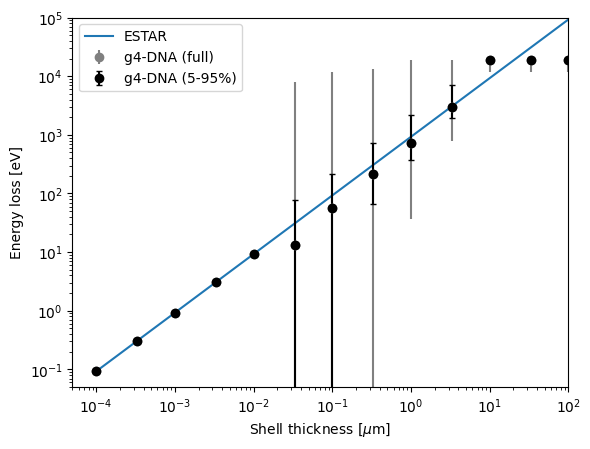

In [191]:
plt.figure()
plt.loglog(thick_list*m_to_um, estar_eng_loss * keV_to_eV, label="ESTAR")

err_tot_lo = sim_thick_range[:,1] - sim_thick_range[:,2]
err_tot_hi = sim_thick_range[:,3] - sim_thick_range[:,1]
plt.errorbar(sim_thick_range[:,0]*nm_to_um, sim_thick_range[:,1], yerr=[err_tot_lo, err_tot_hi], fmt='o', color='gray', label="g4-DNA (full)")
err_tot_lo = sim_thick_range[:,1] - sim_thick_range[:,4]
err_tot_hi = sim_thick_range[:,5] - sim_thick_range[:,1]
plt.errorbar(sim_thick_range[:,0]*nm_to_um, sim_thick_range[:,1], yerr=[err_tot_lo, err_tot_hi], fmt='o', color='k', capsize=2, label="g4-DNA (5-95%)")

plt.xlim(5e-5, 100)
plt.ylim(5e-2, 1e5)
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Energy loss [eV]")
plt.legend()

In [192]:
## now use nominal cross section to figure out what fraction scatter

sigma_inelastic = 3.4e-18 # cm^2

num_density = solid_T_rho/(T_molar_mass * amu_to_g) ## volume number density in cm^{-3}

print("Number density is: [cm^{-3}] ", num_density)

## first the column density
column_density = num_density * thick_list/cm_to_m # cm^{-2}
KATRIN_cd = 5e17 # cm^{-2}

## mean number of scatters
mean_num_scatters = column_density * sigma_inelastic

fraction_unscattered = poisson.cdf(0, mean_num_scatters)


Number density is: [cm^{-3}]  5.992138314531335e+22


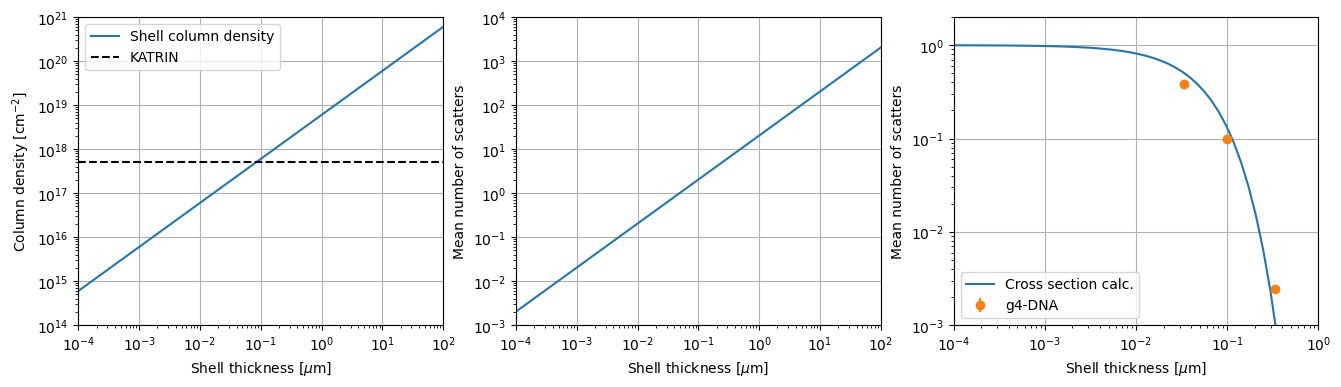

In [195]:
plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
plt.loglog(thick_list*m_to_um, column_density, label="Shell column density")
plt.plot(thick_list*m_to_um, KATRIN_cd*np.ones_like(thick_list), 'k--', label="KATRIN")
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Column density [cm$^{-2}$]")
plt.grid(True)
plt.xlim(1e-4, 100)
plt.ylim(1e14, 1e21)
plt.legend()


plt.subplot(1, 3, 2)
plt.loglog(thick_list*m_to_um, mean_num_scatters)
plt.xlim(1e-4, 100)
plt.ylim(1e-3, 1e4)  
plt.grid(True) 
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Mean number of scatters")

plt.subplot(1, 3, 3)
plt.loglog(thick_list*m_to_um, fraction_unscattered, label="Cross section calc.")
plt.errorbar(sim_thick_range[:,0]*nm_to_um, unscattered_fraction[:,0], yerr=unscattered_fraction[:,1], fmt='o', label="g4-DNA")
plt.xlim(1e-4, 1)
plt.ylim(1e-3, 2)  
plt.grid(True) 
plt.xlabel("Shell thickness [$\mu$m]")
plt.ylabel("Mean number of scatters")
plt.legend(loc = "lower left")


plt.show()

In [ ]:
## now let's look at the necessary charge